In [1]:
# Compare result of lora and freeze
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from MlflowHelper import *
from DensePoisson import *
from PlotHelper import *
import mlflow


import scienceplots
plt.style.use('science')


In [21]:
case_name = 'different PDE'
exp_name = 'lora-fixstep-diffpde'

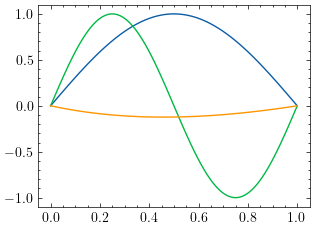

: 

In [7]:
base = PoissonProblem(p=1,exact_D=1)
D = 1
x = torch.linspace(0,1,100)
y = base.u_exact(x,D)
fig, ax = plt.subplots()
ax.plot(x,y, label='base case')

base.p = 2.0
y2 = base.u_exact(x,D)
ax.plot(x,y2, label='different forcing')

prob2 = PoissonProblem2(p=1,exact_D=1)
y3 = prob2.u_exact(x,D)
ax.plot(x,y3, label='different PDE')


In [22]:
h = MlflowHelper()
runs = mlflow.search_runs(experiment_names=[exp_name])

In [23]:
res_list = []
data_list = []
total_list = []
step_list = []

# For each run, get the metrics history
for run in runs.iterrows():
    run_id = run[1]['run_id']
    # Get history
    history,_ = h.get_metric_history(run_id)
    
    # Append the 'res' and 'data' histories to the lists
    res_list.append(history['res'])
    data_list.append(history['data'])
    total_list.append(history['total'])
    step_list.append(history['steps'])

# Add the 'res' and 'data' columns to the DataFrame
runs['res'] = res_list
runs['data'] = data_list
runs['total'] = total_list
runs['steps'] = step_list

res 1.6833091649459675e-05
data 2.53633988811508e-11
total 1.6833117115311325e-05
D 1.0
res 1.361401973554166e-05
data 2.0465410616177238e-11
total 1.3614040653919801e-05
D 1.0
res 15.67668628692627
data 0.12240655720233917
total 15.799093246459961
D 1.0
res 2.144202335330192e-05
data 3.244230578625107e-11
total 2.1442056095111184e-05
D 1.0
res 2.45734081545379e-05
data 3.6692059113274667e-11
total 2.4573444534325972e-05
D 1.0
res 3.32557647197973e-07
data 6.270824788254248e-13
total 3.3255827247558045e-07
D 1.0
res 1.6054796105891e-06
data 1.5503397177152323e-12
total 1.6054812022048282e-06
D 1.0
res 8.794204768491909e-05
data 1.29810373561412e-09
total 8.794334280537441e-05
D 1.0
res 4.108324446860934e-06
data 2.057655044615525e-12
total 4.108326720597688e-06
D 1.0
res 1.3061435311101377e-07
data 9.134199168250087e-15
total 1.3061436732186849e-07
D 1.0
res 2.349988790228963e-06
data 4.572435637582861e-13
total 2.3499892449763138e-06
D 1.0
res 0.007432728074491024
data 5.4508800531039

In [24]:

def create_legend_name(row):
    if row['params.transfer_method'] == 'lora' and 'params.rank' in row:
        return f'LoRA rank {row["params.rank"]}'
    elif row['params.transfer_method'] == 'freeze' and 'params.nlayer_train' in row:
        return f'FT top {row["params.nlayer_train"]}'
    else:
        return 'Unknown'

def compute_parameters(row):
    if row['params.transfer_method'] == 'lora' and 'params.rank' in row:
        return int(row['params.rank']) * 64 * 3
    elif row['params.transfer_method'] == 'freeze' and 'params.nlayer_train' in row:
        return 64 + ( int(row['params.nlayer_train']) - 1) * (64*64 + 64)
    else:
        return None

runs['parameters'] = runs.apply(compute_parameters, axis=1)

runs['legend_name'] = runs.apply(create_legend_name, axis=1)

In [25]:
runs.legend_name
runs.parameters

0       768
1       576
2        64
3       192
4       384
5      8384
6     12544
7      4224
8       192
9     12544
10     8384
11     4224
12      768
13      384
14      576
15       64
Name: parameters, dtype: int64

In [26]:
runs['tags.mlflow.runName']

0      lora_rk4_noff
1      lora_rk3_noff
2     freeze_l1_noff
3      lora_rk1_noff
4      lora_rk2_noff
5     freeze_l3_noff
6     freeze_l4_noff
7     freeze_l2_noff
8        lora_rk1_ff
9       freeze_l4_ff
10      freeze_l3_ff
11      freeze_l2_ff
12       lora_rk4_ff
13       lora_rk2_ff
14       lora_rk3_ff
15      freeze_l1_ff
Name: tags.mlflow.runName, dtype: object

/tmp/ipykernel_184104/3958983840.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_to_plot.sort_values('tags.mlflow.runName', inplace=True)


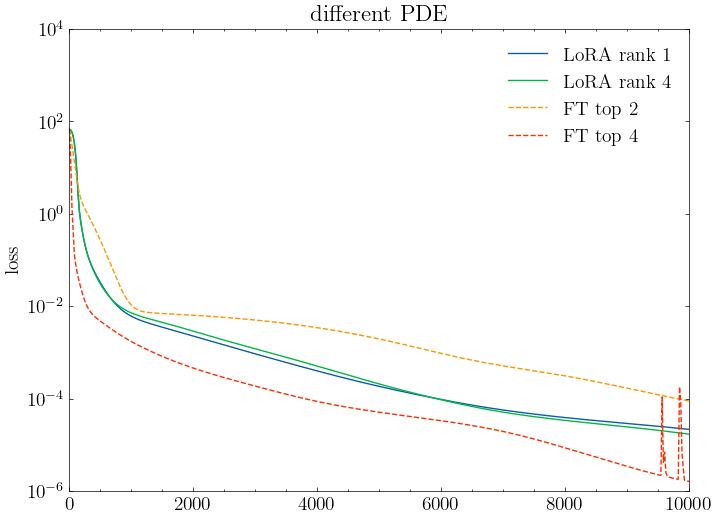

In [27]:
import pandas as pd
import numpy as np
plt.rcParams['font.size'] = 14


runs_plot = ['lora_rk1_noff', 'lora_rk4_noff','freeze_l2_noff','freeze_l4_noff']
window_size = 1
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F'])

# Filter the DataFrame to include only the runs you want to plot
runs_copy = runs.copy()

runs_copy['tags.mlflow.runName'] = pd.Categorical(runs_copy['tags.mlflow.runName'], categories=runs_plot, ordered=True)
runs_to_plot = runs_copy[runs_copy['tags.mlflow.runName'].isin(runs_plot)]
runs_to_plot.sort_values('tags.mlflow.runName', inplace=True)

# Create a new figure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


# For each run to plot, plot the 'data' sequence
for _, run in runs_to_plot.iterrows():
    # Get the 'data' sequence and the legend name
    data = pd.Series(run['total'])

    # data = np.log1p(data)
    # data = data.rolling(window_size).mean()
    # data = np.log10(data)

    legend_name = f'{run["legend_name"]}'

    # Determine the line style based on the transfer method
    if run['params.transfer_method'] == 'lora':
        line_style = '-'
    else:
        line_style = '--'

    # Plot the 'data' sequence
    x = np.arange(len(data))*20
    ax.plot(x, data, line_style, label=legend_name)

# Set the y-axis to log scale
# plt.yscale('log')

# Show the legend
ax.legend(loc='upper right', framealpha=0.5)
ax.set_ylabel('loss')
ax.set_yscale('log')

# ticks = np.log1p([1e-0, 1e-1, 1e-2, 1e-3,])
# plt.yticks(ticks, [f'{tick:.0e}' for tick in np.expm1(ticks)])

# set x lim
ax.set_title(f'{case_name}')
ax.set_xlim(0, 10000)
ax.set_ylim(1e-6, 1e4)
fig.set_dpi(100)

In [30]:

base = 'lora-fixstep:p1D1_noff'
base_model, _ = load_model(name_str = base)

transfer = f'{exp_name}:freeze_l4_noff'
target_model, _ = load_model(name_str = transfer)

layer_name = 'hidden_layers.1.weight'

s1,s2,s_diff = output_svd(base_model, target_model, layer_name)


net loaded from /home/ziruz16/adjointpinn/mlruns/690849876767752235/c724c616dacf45d5aafe86f56207404e/artifacts/net.pth
net loaded from /home/ziruz16/adjointpinn/mlruns/133425984149292882/ab99c22117714132a5ee2a5eeddcab0a/artifacts/net.pth


(1e-08, 100)

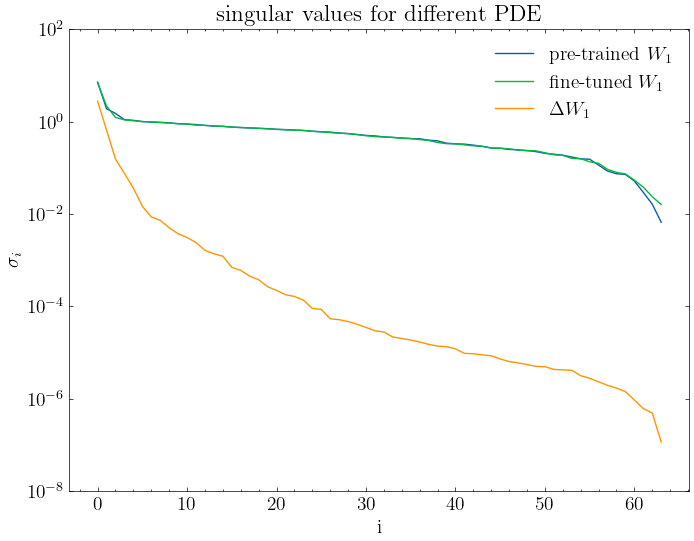

In [31]:

fig, ax = plot_svd(s1, s2, s_diff, 'pre-trained $W_1$', 'fine-tuned $W_1$', '$\Delta W_1$')
fig.set_dpi(100)
ax.set_xlabel('i')
ax.set_ylabel('$\sigma_i$')
ax.legend()
ax.set_title(f'singular values for {case_name}')
ax.set_ylim(1e-8, 100)